In [0]:
# Dependencies
import requests
import datetime
import pandas as pd
import math 
from IPython import display # For updating the cell dynamically
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
from math import ceil

In [0]:
"""
Adapted from from Stefanie Molin: Hands-On-Data-Analysis-With-Pandas. Available at:
https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/tree/master/ch_04
"""

def make_request(endpoint, payload=None):
    """
    Make a request to a specific endpoint on the weather API
    passing headers and optional payload.
    
    Parameters:
        - endpoint: The endpoint of the API you want to 
                    make a GET request to.
        - payload: A dictionary of data to pass along 
                   with the request.
    
    Returns:
        Response object.
    """
    return requests.get(
        f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
        headers={
            'token': 'DOENrJHGTEFUiebNMWZLniFJXUGTiVxr'
        },
        params=payload
    )

In [0]:
def GetData(stationid, startYear, endYear, sampleFreq):
    """
    This function grabs min and max daily temperature data for a chosen station from NOAA GHCND climate dataset.
    It then calculates the average temperature over a chosen date range.
    
    Parameters:
        - stationid:  A string of the GHCND station identifier
                      Example : GHCND:UK000000000
        - startYear:  Integer of first year of date range
        - endYear:    Integer of last year of date range
        - sampleFreq: String of pandas DateOffset alias (e.g. "12M" for 12 month resampling)
                      For documentation, see https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
    
    Returns:
        Pandas dataframe of mean temperatures (TAvg)
    """

    start = startYear
    end = endYear

    results = []

    while start <= end:
        
        currentStart = datetime.date(start, 1, 1)
        currentEnd = datetime.date(start + 1, 1, 1)
        
        # Update the cell with status information
        display.clear_output(wait=True)
        display.display(f'Gathering data for {str(currentStart)}')
        
        response = make_request('data', 
            {
                'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
                'stationid' : stationid, # Station ID
                'startdate' : currentStart,
                'enddate' : currentEnd,
                'units' : 'metric', # Temperature units are degrees C
                'limit' : 1000 # Return maximum allowed
            })

        if response.ok:
            # We extend the list instead of appending to avoid getting a nested list
            results.extend(response.json()['results'])

        # Update the current date to avoid an infinite loop
        start += 1
        
    # Convert to Pandas Dataframe and tidy
    df = pd.DataFrame(results)
    del df["attributes"] # Needles
    df["date"] = df["date"].str[:10] # Get ride of time stamp
    df["date"] = df.apply(lambda x: datetime.datetime.strptime(x["date"], "%Y-%m-%d"), axis = 1) # Convert dates to datetime format
    df = df.groupby("date").mean() # Take mean of Tmax and Tmin
    df.rename(columns = {"value" : "TAvg"}, inplace = True)
           
    # Re-sample at chosen frequency and return dataframe
    return df.resample(sampleFreq).mean()

In [0]:
# Define parameters
startYear = 1950
endYear = 1970
stationid = "GHCND:UK000003026" # Stornoway, UK
sampleFreq = "AS" # Yearly

In [6]:
# Get dataframe
df = GetData(stationid, startYear, endYear, sampleFreq)

'Gathering data for 1970-01-01'

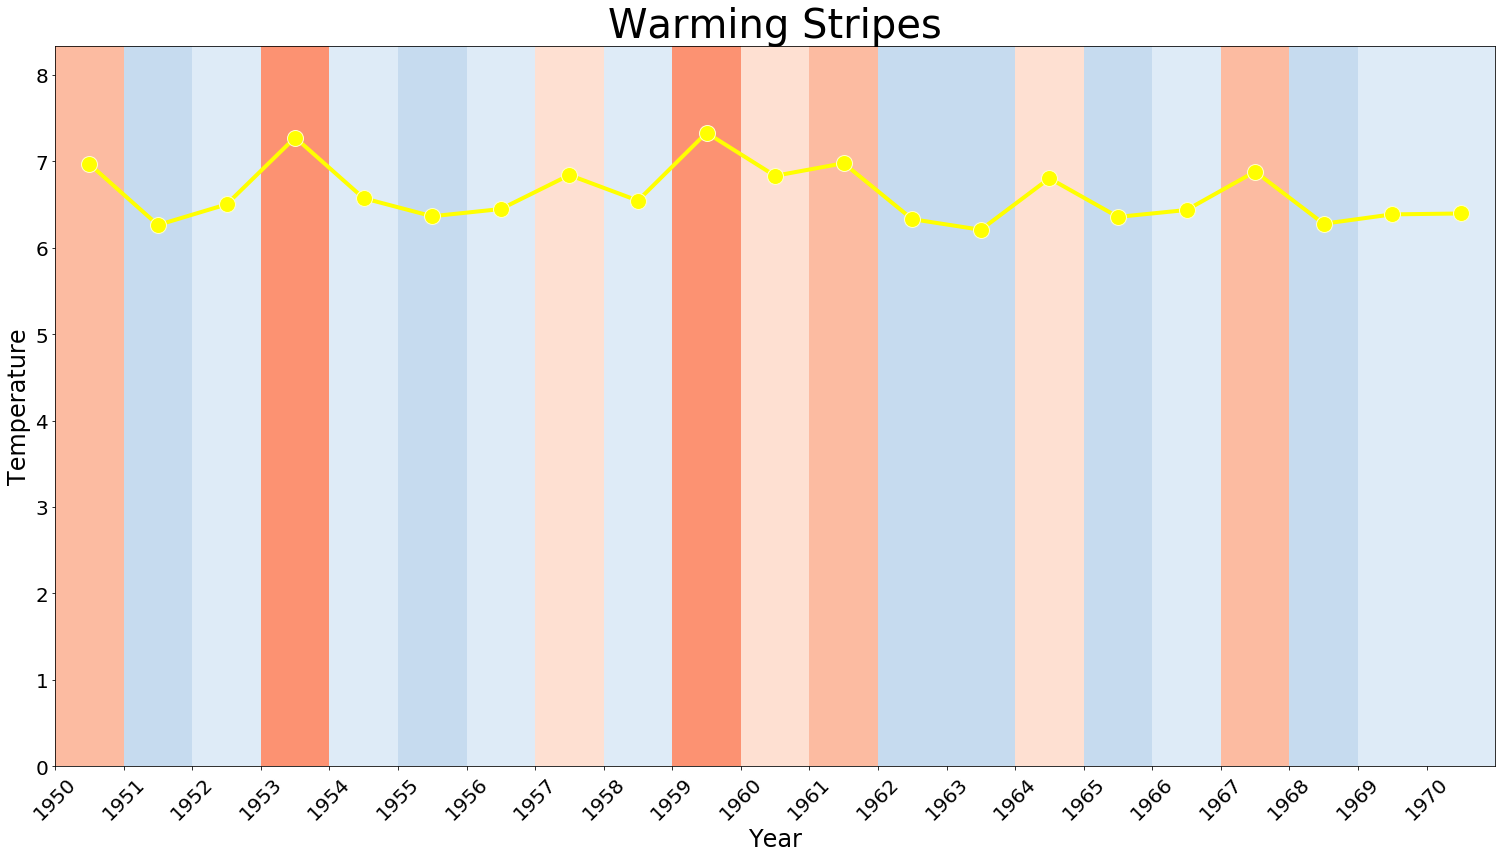

In [44]:
# Warming stripes (adapted from https://matplotlib.org/matplotblog/posts/warming-stripes/)
reference = df["TAvg"].mean()
lim = 2.0

y_max = df["TAvg"].max()+1
y_min = df["TAvg"].min()-1

cmap = ListedColormap([
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
])

fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0, 0, 1, 1])

# create a collection with a rectangle for each year
col = PatchCollection([
    Rectangle((y, 0), 1, y_max)
    for y in range(startYear, endYear + 1)
])


# set data, colormap and color limits
col.set_array(df["TAvg"])
col.set_cmap(cmap)
col.set_clim(reference - lim, reference + lim)
ax.add_collection(col)

ax.set_ylim(0, y_max)
ax.set_xlim(startYear, endYear + 1)
plt.xticks(df.index.year, fontsize=20)
plt.xticks(rotation=45)
plt.xlabel('Year', fontsize=24)
plt.yticks(range(0, 1+ceil(df["TAvg"].max()), 1), fontsize=20)
plt.ylabel('Temperature', fontsize=24)

ax.plot(df.index.year + 0.5, df["TAvg"], color = 'yellow', marker='o', mec='#ffffcc', linewidth=4, markersize=16, zorder = 1)

plt.title('Warming Stripes', fontsize=40)

plt.show()
plt.close()